## LIBRARY

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten

## DATA PREPARATION

In [2]:
%%writefile indodataset.json
{
  "intents": [
    {
      "tag": "sapaan",
      "input": [
        "Hai",
        "Halo",
        "Ada orang di sana?",
        "Hai di sana",
        "Halo di sana",
        "Hei di sana",
        "Hola",
        "Bonjour",
        "Konnichiwa",
        "Guten tag",
        "Ola",
        "Apa kabar?",
        "Hey",
        "Selamat pagi, siang, malam",
        "Hai, apa kabar?",
        "Halo, senang bertemu denganmu",
        "Selamat datang"
      ],
      "responses": [
        "Halo! Bagaimana kabarmu hari ini?",
        "Hai! Apa yang bisa aku bantu hari ini?",
        "Hai! Bagaimana perasaanmu hari ini?",
        "Senang bertemu denganmu. Bagaimana kabarmu?",
        "Halo! Senang melihatmu lagi. Ada yang ingin kamu ceritakan?",
        "Hey! Bagaimana harimu?",
        "Halo! Ada yang bisa kubantu?",
        "Hai! Ada yang ingin kamu bicarakan?",
        "Selamat datang! Bagaimana harimu?"
      ]
    },
    {
      "tag": "pagi",
      "input": [
        "Selamat pagi",
        "Pagi!",
        "Hai, selamat pagi",
        "Pagi, bagaimana kabarmu?",
        "Pagi, apa rencanamu hari ini?",
        "Good morning"
      ],
      "responses": [
        "Selamat pagi! Tidurmu nyenyak? Bagaimana kabarmu hari ini?",
        "Pagi! Apa rencanamu hari ini?",
        "Selamat pagi! Semoga harimu menyenangkan.",
        "Pagi! Ada yang bisa aku bantu?",
        "Pagi! Bagaimana tidurmu tadi malam?",
        "Good morning! How are you today?"
      ]
    },
    {
      "tag": "siang",
      "input": [
        "Selamat siang",
        "Siang!",
        "Hai, selamat siang",
        "Siang, bagaimana harimu?",
        "Selamat siang, bagaimana kabarmu?",
        "Good afternoon"
      ],
      "responses": [
        "Selamat siang! Bagaimana harimu sejauh ini?",
        "Siang! Ada yang ingin dibicarakan?",
        "Selamat siang! Apa kabar?",
        "Siang! Bagaimana harimu berjalan?",
        "Siang! Ada yang bisa aku bantu?",
        "Good afternoon! How's your day going?"
      ]
    },
    {
      "tag": "malam",
      "input": [
        "Selamat malam",
        "Malam!",
        "Hai, selamat malam",
        "Malam, bagaimana harimu?",
        "Selamat malam, bagaimana kabarmu?",
        "Good evening"
      ],
      "responses": [
        "Selamat malam! Bagaimana harimu tadi?",
        "Malam! Ada yang ingin kamu ceritakan?",
        "Selamat malam! Apa kabar?",
        "Malam! Bagaimana harimu?",
        "Malam! Ada yang bisa aku bantu?",
        "Good evening! How was your day?"
      ]
    },
    {
      "tag": "selamat_tidur",
      "input": [
        "Selamat tidur",
        "Tidur nyenyak ya",
        "Good night",
        "Selamat malam, tidur yang nyenyak",
        "Tidur yang nyenyak",
        "Mimpi indah"
      ],
      "responses": [
        "Selamat tidur! Semoga tidurmu nyenyak.",
        "Selamat tidur! Mimpi indah ya.",
        "Tidur yang nyenyak!",
        "Selamat malam! Semoga esok harimu cerah.",
        "Selamat tidur! Sampai jumpa besok.",
        "Good night! Sweet dreams."
      ]
    },
    {
      "tag": "selamat_tinggal",
      "input": [
        "Sampai jumpa",
        "Sampai nanti",
        "Selamat tinggal",
        "Au revoir",
        "Sayonara",
        "Ok bye",
        "Bye bye",
        "Dadah",
        "Sampai ketemu lagi",
        "Goodbye"
      ],
      "responses": [
        "Sampai jumpa lagi!",
        "Semoga harimu menyenangkan!",
        "Bye! Kembali lagi ya.",
        "Sampai jumpa lagi segera.",
        "Dadah! Sampai bertemu lagi.",
        "Selamat tinggal! Jaga diri baik-baik.",
        "Sampai jumpa lagi! Jangan lupa kembali.",
        "Goodbye! Take care."
      ]
    },
    {
      "tag": "terima_kasih",
      "input": [
        "Terima kasih",
        "Terima kasih banyak",
        "Itu membantu",
        "Terima kasih atas bantuannya",
        "Terima kasih banyak",
        "Makasih ya",
        "Thanks",
        "Terima kasih ya",
        "Thanks a lot",
        "Thanks for your help",
        "Aku berterima kasih",
        "Thank you"
      ],
      "responses": [
        "Senang bisa membantu!",
        "Kapan saja!",
        "Dengan senang hati!",
        "Sama-sama!",
        "Tidak masalah, senang bisa membantu.",
        "Terima kasih kembali!",
        "Aku senang bisa membantu.",
        "Itu bukan masalah sama sekali.",
        "You're welcome!"
      ]
    },
    {
      "tag": "tidak_ada_respon",
      "input": [
        "",
        "........",
        "???",
        "Tidak ada yang dikatakan",
        "Hening",
        "Diam saja"
      ],
      "responses": [
        "Maaf, aku tidak mengerti.",
        "Silakan lanjutkan.",
        "Aku tidak yakin aku mengerti itu.",
        "Jangan ragu untuk berbicara denganku.",
        "Maaf, bisa ulangi?",
        "Aku di sini, ceritakan saja.",
        "Kamu tidak sendirian, aku di sini."
      ]
    },
    {
      "tag": "respon_netral",
      "input": [
        "tidak banyak",
        "biasa saja",
        "nothing",
        "nothing much",
        "tidak ada yang spesial",
        "biasa saja",
        "tidak ada yang baru",
        "tidak ada yang menarik"
      ],
      "responses": [
        "Oh begitu. Ada yang ingin kamu bicarakan?",
        "Oke, kalau begitu ada yang bisa aku bantu?",
        "Baiklah, kalau ada yang ingin dibicarakan, aku di sini.",
        "Mengerti. Apakah ada sesuatu yang ingin kamu ceritakan?",
        "Itu terdengar santai. Apa ada yang bisa aku bantu?",
        "Kalau begitu, mari kita bicarakan sesuatu yang lain."
      ]
    },
    {
      "tag": "tentang",
      "input": [
        "Siapa kamu?",
        "Apa kamu?",
        "Siapa kamu?",
        "Ceritakan lebih banyak tentang dirimu.",
        "Apa namamu?",
        "Bagaimana saya harus memanggilmu?",
        "Siapa namamu?",
        "Ceritakan tentang dirimu",
        "Kamu siapa?",
        "Kenalkan dirimu",
        "Apa pekerjaanmu?"
      ],
      "responses": [
        "Aku Pandora, Asisten Terapi AI pribadimu. Bagaimana kabarmu hari ini?",
        "Aku Pandora, Asisten Terapi AI yang siap membantu. Ceritakan tentang dirimu.",
        "Aku Pandora. Aku di sini untuk membantumu. Jadi, bagaimana perasaanmu hari ini?",
        "Kamu bisa panggil aku Pandora.",
        "Aku Pandora!",
        "Panggil saja aku Pandora.",
        "Aku di sini untuk mendengarkan dan membantu.",
        "Aku adalah AI yang dirancang untuk mendukung kesehatan mental."
      ]
    },
    {
      "tag": "kemampuan",
      "input": [
        "Apa yang bisa kamu lakukan?",
        "Bisa bantu apa?",
        "Kamu bisa ngapain?",
        "Apa kemampuanmu?",
        "Kamu bisa apa?",
        "Apa fungsimu?"
      ],
      "responses": [
        "Aku bisa memberikan saran umum tentang kecemasan dan depresi, menjawab pertanyaan tentang kesehatan mental, dan berbicara tentang berbagai hal. Tapi ingat, aku bukan pengganti terapis sebenarnya. Cari bantuan profesional jika kamu merasa perlu.",
        "Aku di sini untuk mendengarkan dan memberikan saran mengenai kesehatan mental. Kalau ada yang ingin kamu bicarakan, ceritakan saja.",
        "Aku bisa membantu kamu memahami perasaanmu lebih baik. Aku juga bisa memberikan informasi dan dukungan emosional.",
        "Aku bisa menjadi teman bicara yang selalu siap mendengarkan.",
        "Aku bisa memberikan panduan untuk relaksasi dan meditasi."
      ]
    },
    {
      "tag": "penciptaan",
      "input": [
        "Siapa yang menciptakanmu?",
        "Bagaimana kamu dibuat?",
        "Bagaimana kamu diciptakan?",
        "Siapa yang bikin kamu?",
        "Siapa pembuatmu?",
        "Bagaimana kamu tercipta?"
      ],
      "responses": [
        "Aku diciptakan oleh Bangkit Super Cohort.",
        "Aku dilatih menggunakan data teks dengan teknik Pembelajaran Mendalam oleh Bangkit Super Cohort.",
        "Aku adalah hasil dari proyek Bangkit Super Cohort.",
        "Tim Bangkit Super Cohort yang mengembangkanku.",
        "Aku dibangun menggunakan teknologi canggih oleh Bangkit Super Cohort."
      ]
    },
    {
      "tag": "perpisahan",
      "input": [
        "Sampai jumpa",
        "Dadah",
        "Selamat tinggal",
        "Sampai bertemu lagi",
        "Goodbye",
        "See you later",
        "Sayonara"
      ],
      "responses": [
        "Sampai jumpa lagi! Semoga harimu menyenangkan.",
        "Selamat tinggal! Jaga dirimu baik-baik.",
        "Sampai bertemu lagi. Tetap sehat dan semangat!",
        "Goodbye! Have a great day.",
        "Sampai jumpa lagi! Jangan ragu untuk kembali.",
        "Dadah! Sampai jumpa di lain waktu."
      ]
    },
    {
      "tag": "cuaca",
      "input": [
        "Bagaimana cuaca hari ini?",
        "Apakah akan hujan hari ini?",
        "Cuaca di luar seperti apa?",
        "Hari ini cerah atau tidak?",
        "Apakah cuaca mendukung untuk jalan-jalan?",
        "Perkiraan cuaca hari ini bagaimana?",
        "Cuaca hari ini bagaimana?",
        "Apakah besok cerah?",
        "Apakah akan turun salju?",
        "Bagaimana cuaca di tempatku?"
      ],
      "responses": [
        "Untuk mengetahui cuaca hari ini, kamu bisa cek aplikasi cuaca di ponselmu.",
        "Cek aplikasi cuaca favoritmu untuk mengetahui detailnya.",
        "Sayangnya aku tidak bisa memberikan informasi cuaca langsung, tapi kamu bisa menggunakan aplikasi cuaca di ponselmu.",
        "Lebih baik cek aplikasi cuaca di ponselmu untuk info yang lebih akurat.",
        "Untuk info cuaca terkini, gunakan aplikasi cuaca di ponselmu."
      ]
    },
    {
      "tag": "mood",
      "input": [
        "Aku merasa sedih",
        "Aku merasa senang",
        "Aku cemas",
        "Aku marah",
        "Aku tenang",
        "Aku kecewa",
        "Aku stres",
        "Aku bahagia",
        "Aku bingung",
        "Aku khawatir",
        "Aku gelisah"
      ],
      "responses": [
        "Terima kasih sudah berbagi. Bagaimana aku bisa membantumu?",
        "Aku di sini untuk mendengarkan. Ceritakan lebih banyak tentang perasaanmu.",
        "Emosi yang kamu rasakan valid. Apa yang bisa aku bantu?",
        "Mengerti. Apakah ada sesuatu yang spesifik yang ingin kamu bicarakan?",
        "Emosi adalah bagian dari kehidupan. Ceritakan lebih banyak jika kamu mau.",
        "Aku mendengarmu. Bagaimana aku bisa membantu mengurangi perasaan ini?"
      ]
    },
    {
      "tag": "hiburan",
      "input": [
        "Rekomendasi film dong",
        "Ada rekomendasi buku?",
        "Kasih rekomendasi musik",
        "Film apa yang bagus?",
        "Lagu apa yang enak didengar?",
        "Buku apa yang harus aku baca?"
      ],
      "responses": [
        "Untuk film, coba tonton yang bergenre drama atau komedi. Misalnya 'The Pursuit of Happyness' atau 'Forrest Gump'.",
        "Untuk buku, coba baca 'To Kill a Mockingbird' oleh Harper Lee atau '1984' oleh George Orwell.",
        "Untuk musik, dengarkan album 'Abbey Road' oleh The Beatles atau 'Thriller' oleh Michael Jackson.",
        "Aku tidak bisa memberikan rekomendasi spesifik, tapi cobalah genre yang kamu sukai."
      ]
    },
    {
      "tag": "makanan",
      "input": [
        "Makanan enak apa hari ini?",
        "Apa yang harus aku masak?",
        "Rekomendasi tempat makan dong",
        "Makanan favoritmu apa?",
        "Masakan apa yang gampang dibuat?",
        "Apa yang harus aku makan?"
      ],
      "responses": [
        "Coba makanan khas daerahmu atau masakan yang kamu sukai.",
        "Untuk masakan simpel, coba buat nasi goreng atau mie goreng.",
        "Untuk tempat makan, kamu bisa coba cari restoran lokal dengan ulasan yang bagus.",
        "Aku tidak makan, tapi aku tahu banyak orang suka pizza atau sushi.",
        "Coba masakan yang sederhana dan cepat dibuat, seperti sandwich atau salad."
      ]
    },
    {
      "tag": "perjalanan",
      "input": [
        "Rekomendasi tempat wisata dong",
        "Tempat liburan yang bagus apa?",
        "Liburan kemana ya enaknya?",
        "Tempat wisata terkenal apa?",
        "Rekomendasi destinasi wisata?",
        "Tempat jalan-jalan yang seru apa?"
      ],
      "responses": [
        "Coba kunjungi destinasi populer seperti Bali, Yogyakarta, atau Lombok.",
        "Untuk liburan, coba tempat yang menawarkan pemandangan alam indah seperti Raja Ampat atau Bromo.",
        "Jika suka budaya, kunjungi kota bersejarah seperti Ubud atau Toraja.",
        "Untuk petualangan, cobalah mendaki gunung atau menyelam di pulau tropis.",
        "Banyak tempat menarik di Indonesia, seperti Komodo Island atau Labuan Bajo."
      ]
    },
    {
      "tag": "motivasi",
      "input": [
        "Butuh motivasi",
        "Kasih kata-kata semangat dong",
        "Aku butuh dorongan",
        "Bisa kasih motivasi?",
        "Motivasi untuk hari ini?",
        "Semangatin aku dong"
      ],
      "responses": [
        "Kamu bisa melakukannya! Percayalah pada dirimu sendiri.",
        "Jangan pernah menyerah, setiap usaha pasti ada hasilnya.",
        "Setiap hari adalah kesempatan baru untuk menjadi lebih baik.",
        "Kamu kuat dan mampu menghadapi apapun yang datang.",
        "Yakinlah, kamu lebih kuat dari yang kamu kira.",
        "Tetap semangat! Setiap langkah kecil membawa kamu lebih dekat ke tujuanmu."
      ]
    },
    {
      "tag": "olahraga",
      "input": [
        "Apa olahraga yang bagus?",
        "Aku butuh saran olahraga",
        "Bagaimana cara memulai olahraga?",
        "Apa olahraga yang mudah dilakukan?",
        "Rekomendasi olahraga untuk pemula?",
        "Apa olahraga favoritmu?"
      ],
      "responses": [
        "Cobalah jalan cepat atau jogging di sekitar lingkunganmu.",
        "Yoga atau pilates adalah pilihan bagus untuk pemula.",
        "Olahraga yang bagus adalah yang kamu nikmati dan bisa kamu lakukan secara rutin.",
        "Mulailah dengan latihan ringan seperti peregangan dan berjalan kaki.",
        "Untuk pemula, cobalah bersepeda atau berenang.",
        "Aku tidak berolahraga, tapi banyak orang menikmati jogging atau yoga."
      ]
    },
    {
      "tag": "kesehatan",
      "input": [
        "Bagaimana cara menjaga kesehatan?",
        "Apa tips kesehatan?",
        "Bagaimana cara hidup sehat?",
        "Tips makan sehat?",
        "Bagaimana cara menjaga kebugaran?"
      ],
      "responses": [
        "Pastikan kamu makan makanan seimbang dan cukup beristirahat.",
        "Olahraga secara rutin dan minum banyak air.",
        "Hindari stres berlebihan dan luangkan waktu untuk bersantai.",
        "Makan lebih banyak buah dan sayuran, dan kurangi makanan olahan.",
        "Jaga kebersihan diri dan lingkungan sekitar."
      ]
    },
    {
      "tag": "belajar",
      "input": [
        "Bagaimana cara belajar efektif?",
        "Tips untuk belajar lebih baik?",
        "Cara mengingat pelajaran?",
        "Bagaimana cara fokus saat belajar?",
        "Rekomendasi teknik belajar?"
      ],
      "responses": [
        "Buat jadwal belajar dan patuhi itu.",
        "Coba belajar dalam sesi singkat dengan istirahat di antaranya.",
        "Gunakan teknik mnemonik untuk mengingat informasi.",
        "Temukan tempat yang tenang dan bebas dari gangguan.",
        "Coba metode seperti pomodoro atau mind mapping untuk belajar lebih efektif."
      ]
    },
    {
      "tag": "teknologi",
      "input": [
        "Apa teknologi terbaru?",
        "Berita teknologi terbaru?",
        "Apa gadget terbaru?",
        "Rekomendasi aplikasi?",
        "Bagaimana cara menggunakan [nama aplikasi]?"
      ],
      "responses": [
        "Teknologi terbaru banyak mencakup AI, blockchain, dan Internet of Things (IoT).",
        "Untuk berita teknologi terbaru, cek situs seperti TechCrunch atau The Verge.",
        "Gadget terbaru termasuk smartphone dengan teknologi 5G dan perangkat wearable.",
        "Coba aplikasi produktivitas seperti Trello atau Evernote.",
        "Untuk panduan menggunakan aplikasi, cek situs resmi atau tutorial di YouTube."
      ]
    },
    {
      "tag": "tidak_dikenal",
      "input": [
        "Ini apa?",
        "Kenapa begitu?",
        "Bagaimana bisa?",
        "Apa yang sedang terjadi?",
        "Apa maksudnya?",
        "Aku tidak mengerti",
        "Kenapa begitu?",
        "Bisa jelaskan lebih lanjut?",
        "Apa yang kamu katakan?",
        "Aku bingung",
        "Tolong bantu aku memahami ini"
      ],
      "responses": [
        "Maaf, aku tidak mengerti pertanyaanmu. Bisa jelaskan lebih lanjut?",
        "Aku tidak yakin dengan yang kamu maksud. Bisa berikan lebih banyak detail?",
        "Pertanyaanmu menarik, tapi aku butuh lebih banyak informasi.",
        "Coba jelaskan dengan cara lain, mungkin aku bisa membantu.",
        "Aku tidak yakin memahami itu. Bisa beri lebih banyak konteks?",
        "Bantu aku memahami pertanyaanmu dengan lebih detail."
      ]
    }
  ]
}

Writing indodataset.json


## IMPORT DATA

In [3]:
with open('indodataset.json') as content:
  data1 = json.load(content)

In [4]:
tags = []
inputs = []
responses = {}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent ['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [5]:
data = pd.DataFrame({"inputs": inputs, "tags": tags})
data

,inputs,tags
0,Hai,sapaan
1,Halo,sapaan
2,Ada orang di sana?,sapaan
3,Hai di sana,sapaan
4,Halo di sana,sapaan
...,...,...
179,Kenapa begitu?,tidak_dikenal
180,Bisa jelaskan lebih lanjut?,tidak_dikenal
181,Apa yang kamu katakan?,tidak_dikenal
182,Aku bingung,tidak_dikenal


In [6]:
data = data.sample(frac = 1)
data

,inputs,tags
105,See you later,perpisahan
39,Tidur yang nyenyak,selamat_tidur
157,Apa olahraga favoritmu?,olahraga
101,Dadah,perpisahan
178,Aku tidak mengerti,tidak_dikenal
...,...,...
82,Bagaimana saya harus memanggilmu?,tentang
12,Hey,sapaan
85,Kamu siapa?,tentang
182,Aku bingung,tidak_dikenal


## PRE-PROCESSING

In [7]:
import string
data ['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data ['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
105,see you later,perpisahan
39,tidur yang nyenyak,selamat_tidur
157,apa olahraga favoritmu,olahraga
101,dadah,perpisahan
178,aku tidak mengerti,tidak_dikenal
...,...,...
82,bagaimana saya harus memanggilmu,tentang
12,hey,sapaan
85,kamu siapa,tentang
182,aku bingung,tidak_dikenal


## TOKENIZING

In [8]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
x_train = pad_sequences(train)

label = LabelEncoder()
y_train = label.fit_transform(data['tags'])

In [9]:
input_shape = x_train.shape[1]
print('Input Shape : ', input_shape)
vocab = len(tokenizer.word_index)
print('Number Unique Word : ', vocab)
output_length = label.classes_.shape[0]
print('Output Length : ', output_length)

Input Shape :  6
Number Unique Word :  205
Output Length :  24


## MODEL

In [10]:
#SequentialAPI
model = tf.keras.models. Sequential([
    tf.keras.layers.Embedding(vocab + 1, 32, input_length=input_shape),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(output_length, activation='softmax'),
])

print(model.summary())

# #FunctionalAPI
# i = Input(shape=(input_shape,))
# x = Embedding(vocab+1, 10)(i)
# x = LSTM(10, return_sequences=True)(x)
# x = Flatten()(x)
# x = Dense(output_length, activation='softmax')(x)
# model = Model(i, x)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 32)             6592      
                                                                 
 lstm (LSTM)                 (None, 6, 32)             8320      
                                                                 
 dropout (Dropout)           (None, 6, 32)             0         
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 24)                4632      
                                                                 
Total params: 19544 (76.34 KB)
Trainable params: 19544 (76.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [12]:
train = model.fit(x_train,
                  y_train,
                  epochs=100)

Epoch 1/100
6/6 [==============================] - 9s 151ms/step - loss: 3.1774 - accuracy: 0.0598
Epoch 2/100
6/6 [==============================] - 0s 34ms/step - loss: 3.1692 - accuracy: 0.1304
Epoch 3/100
6/6 [==============================] - 0s 99ms/step - loss: 3.1608 - accuracy: 0.1522
Epoch 4/100
6/6 [==============================] - 0s 92ms/step - loss: 3.1526 - accuracy: 0.1413
Epoch 5/100
6/6 [==============================] - 0s 65ms/step - loss: 3.1412 - accuracy: 0.1685
Epoch 6/100
6/6 [==============================] - 0s 95ms/step - loss: 3.1263 - accuracy: 0.1793
Epoch 7/100
6/6 [==============================] - 0s 63ms/step - loss: 3.1085 - accuracy: 0.1739
Epoch 8/100
6/6 [==============================] - 0s 66ms/step - loss: 3.0811 - accuracy: 0.1087
Epoch 9/100
6/6 [==============================] - 0s 64ms/step - loss: 3.0525 - accuracy: 0.1522
Epoch 10/100
6/6 [==============================] - 0s 6ms/step - loss: 3.0186 - accuracy: 0.1087
Epoch 11/100
6/6 [=

In [13]:
loss, accuracy = model.evaluate(x_train, y_train)

print("Loss:", loss)
print("Accuracy:", accuracy)

6/6 [==============================] - 0s 4ms/step - loss: 0.1496 - accuracy: 0.9620
Loss: 0.14958420395851135
Accuracy: 0.9619565010070801


## MONITORING

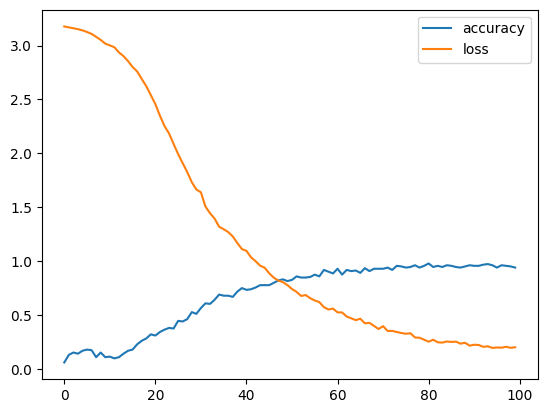

In [14]:
plt.plot(train.history['accuracy'], label='accuracy')
plt.plot(train.history['loss'], label='loss')
plt.legend()

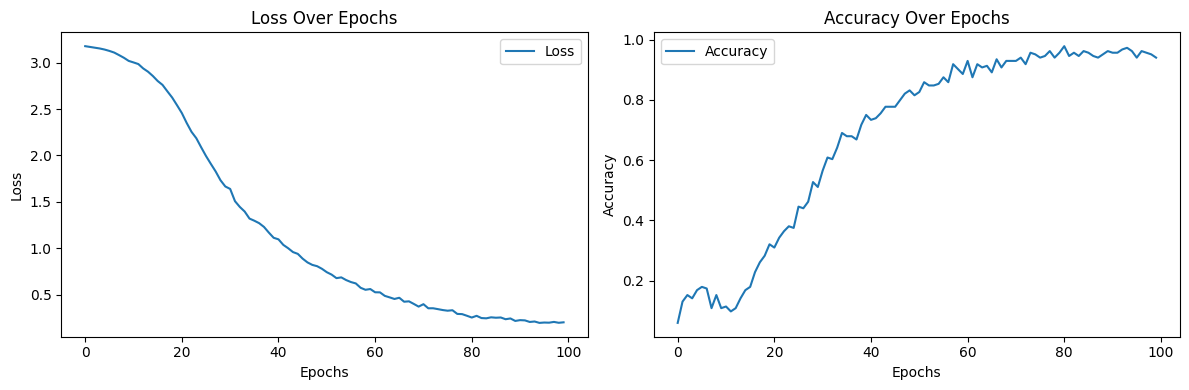

In [15]:
def plot_train_history(train):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train.history['loss'], label='Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train.history['accuracy'], label='Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_train_history(train)

# SAVE MODEL

In [16]:
model.save("chatbot_indomodel.h5")
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(label, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Load necessary files
modelikianyar = tf.keras.models.load_model('chatbot_indomodel.h5')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
with open('label_encoder.pickle', 'rb') as enc_file:
    lbl_encoder = pickle.load(enc_file)
with open('indodataset.json', 'r') as data_file:
    data1 = json.load(data_file)

# TESTING MODEL

In [18]:
pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=187482 sha256=43678090e25f9ed0041a2897a563c658f0fe94559c64bb80f5caa7d1d27b9bf6
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built editdistpy


In [19]:
from symspellpy.symspellpy import SymSpell, Verbosity

# Initialize SymSpell for typo correction
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

def correct_typo(input_text):
    suggestions = sym_spell.lookup_compound(input_text, max_edit_distance=2)
    # Return the corrected input if any suggestions exist
    if suggestions:
        return suggestions[0].term
    return input_text

def chat():
    print("Start chatting with the bot (type 'quit' to stop)!")
    while True:
        print("User: ", end="")
        inp = input()
        if inp.lower() == "quit":
            break

        # Correct typos in user input
        corrected_input = correct_typo(inp)

        # Process the corrected input
        result = model.predict(pad_sequences(tokenizer.texts_to_sequences([corrected_input]), truncating='post', maxlen=input_shape))
        tag = lbl_encoder.inverse_transform([np.argmax(result)])

        for intent in data1['intents']:
            if intent['tag'] == tag:
                print("Chatbot: ", np.random.choice(intent['responses']))

chat()

Start chatting with the bot (type 'quit' to stop)!
User: Halo
1/1 [==============================] - 1s 1s/step
Chatbot:  Hey! Bagaimana harimu?
User: Selamat pagi
1/1 [==============================] - 0s 17ms/step
Chatbot:  Selamat pagi! Tidurmu nyenyak? Bagaimana kabarmu hari ini?
User: Aku stres
1/1 [==============================] - 0s 17ms/step
Chatbot:  Emosi yang kamu rasakan valid. Apa yang bisa aku bantu?
User: Rekomendasi film dong
1/1 [==============================] - 0s 19ms/step
Chatbot:  Untuk film, coba tonton yang bergenre drama atau komedi. Misalnya 'The Pursuit of Happyness' atau 'Forrest Gump'.
User: Butuh motivasi nih
1/1 [==============================] - 0s 17ms/step
Chatbot:  Tetap semangat! Setiap langkah kecil membawa kamu lebih dekat ke tujuanmu.
User: Semangatin aku lagi dong
1/1 [==============================] - 0s 17ms/step
Chatbot:  Kamu kuat dan mampu menghadapi apapun yang datang.
User: Terima kasih banyak ya
1/1 [==============================] - 0s 

# CONVERT TFLITE

In [20]:
model = tf.keras.models.load_model('chatbot_indomodel.h5')

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # TFLite default ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TF ops
]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

In [22]:
tflite_model_path = 'chatbot_indomodel.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to {tflite_model_path}")

TFLite model saved to chatbot_indomodel.tflite
